In [1]:
from math import sqrt
from numpy import concatenate 
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU,SimpleRNN,Conv1D,Dropout,Bidirectional,Permute,Multiply,Flatten,MaxPooling1D
from keras.layers import Input
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pydot
import keras.backend as K
from keras import regularizers
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'#将图片保存为矢量图

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文
plt.rcParams['axes.unicode_minus']=False  #用来正常显示负号

Using TensorFlow backend.


#### 2.2 读取数据
写两个读取数据的函数，excel2train以及excel2test，excel2train从原始excel文件中读取前80%个数据点作为训练集，excel2test从原始excel文件中读取后20%个点作为验证集

In [2]:
def excel2train(path):
    data = pd.read_csv(path,index_col=0)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    train_rows = int(data.shape[0]*0.1)
    train = data[:train_rows,:]
    return train

def excel2test(path):
    data = pd.read_csv(path,index_col=0)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    test_rows = int(data.shape[0]*0.9)
    test = data[test_rows:,:]
    return test

#### 训练数据

In [3]:
path1 = 'C:/Users/shamrockyj/Desktop/毕设：航空发动机智能运维与健康管理/毕业论文/故障数据/VMD后数据/57_44/' #数据路径

In [4]:
traindata_0 = excel2train(path1+'57_44_正常.csv')
traindata_1 = excel2train(path1+'57_44_断齿.csv')
traindata_2 = excel2train(path1+'57_44_缺齿.csv')
traindata_3 = excel2train(path1+'57_44_磨损.csv')
traindata_4 = excel2train(path1+'57_44_裂纹.csv')
traindata_5 = excel2train(path1+'57_44_偏心.csv')
traindata_6 = excel2train(path1+'57_44_滚动体.csv')
traindata_7 = excel2train(path1+'57_44_内圈.csv')
traindata_8 = excel2train(path1+'57_44_外圈.csv')
traindata_9 = excel2train(path1+'57_44_联合.csv')

In [5]:
traindata_0.shape

(307200, 15)

In [6]:
traindata = np.vstack([traindata_0,
                       traindata_1,traindata_2,traindata_3,
                       traindata_4,traindata_5,traindata_6,
                       traindata_7,traindata_8,traindata_9])  #四列数据纵向堆叠

In [7]:
traindata.shape

(3072000, 15)

In [8]:
length = 1024

生成训练数据集1024*15的矩阵及贴标签

In [9]:
channels = traindata.shape[1]
train_x = traindata.reshape(-1,length,channels)
print(train_x.shape)

(3000, 1024, 15)


In [10]:
features = 10
#定义标签生成函数
def LabelGeneration(train0,train1,train2,train3,train4,train5,train6,train7,train8,train9):
    y0 = np.full(train0.shape[0]//length,0)
    y1 = np.full(train1.shape[0]//length,1)
    y2 = np.full(train2.shape[0]//length,2)
    y3 = np.full(train3.shape[0]//length,3)
    y4 = np.full(train4.shape[0]//length,4)
    y5 = np.full(train5.shape[0]//length,5)
    y6 = np.full(train6.shape[0]//length,6)
    y7 = np.full(train7.shape[0]//length,7)
    y8 = np.full(train8.shape[0]//length,8)
    y9 = np.full(train9.shape[0]//length,9)
    
#     each_num = X//features #这里的X为数据总数
    y = []
    for i in range(features):
#         locals()['y'+str(i)] = np.full(each_num,i)
        y = np.append(y,locals()['y'+str(i)])
    return y

In [11]:
train_y = LabelGeneration(traindata_0,
                       traindata_1,traindata_2,traindata_3,
                       traindata_4,traindata_5,traindata_6,
                       traindata_7,traindata_8,traindata_9)

In [12]:
#利用随机数种子对数据和标签进行同顺序打乱
randnum = 100
np.random.seed(randnum)
np.random.shuffle(train_x)
np.random.seed(randnum)
np.random.shuffle(train_y)

#将标签转换为独热码格式
from keras.utils.np_utils import to_categorical
one_hot_train_y = to_categorical(train_y)
print(one_hot_train_y)

#查看标签中每一个故障类别的个数
label = [np.argmax(item)+1 for item in one_hot_train_y]
label
s=set()#定义集合
for i in label:#循环列表中的元素
    if i not in s:#如果i不在集合中
        s.add(i)#将i添加到集合中
        print('Name:{}\tCount:{}'.format(i,label.count(i)))#格式化打印出i、i的count数

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Name:5	Count:300
Name:2	Count:300
Name:7	Count:300
Name:1	Count:300
Name:4	Count:300
Name:9	Count:300
Name:3	Count:300
Name:10	Count:300
Name:8	Count:300
Name:6	Count:300


#### 测试数据

In [13]:
path2 = 'C:/Users/shamrockyj/Desktop/毕设：航空发动机智能运维与健康管理/毕业论文/故障数据/VMD后数据/57_44/' #数据路径

In [14]:
testdata_0 = excel2test(path2+'57_44_正常.csv')
testdata_1 = excel2test(path2+'57_44_断齿.csv')
testdata_2 = excel2test(path2+'57_44_缺齿.csv')
testdata_3 = excel2test(path2+'57_44_磨损.csv')
testdata_4 = excel2test(path2+'57_44_裂纹.csv')
testdata_5 = excel2test(path2+'57_44_偏心.csv')
testdata_6 = excel2test(path2+'57_44_滚动体.csv')
testdata_7 = excel2test(path2+'57_44_内圈.csv')
testdata_8 = excel2test(path2+'57_44_外圈.csv')
testdata_9 = excel2test(path2+'57_44_联合.csv')

In [15]:
testdata_0

array([[0.37781815, 0.49780275, 0.54120847, ..., 0.37781815, 0.49780275,
        0.54120847],
       [0.381657  , 0.49494978, 0.51692924, ..., 0.381657  , 0.49494978,
        0.51692924],
       [0.38922729, 0.49096488, 0.4921277 , ..., 0.38922729, 0.49096488,
        0.4921277 ],
       ...,
       [0.35487842, 0.33852819, 0.55405408, ..., 0.35487842, 0.33852819,
        0.55405408],
       [0.35042551, 0.3187951 , 0.51366592, ..., 0.35042551, 0.3187951 ,
        0.51366592],
       [0.34809515, 0.30848537, 0.4778035 , ..., 0.34809515, 0.30848537,
        0.4778035 ]])

In [16]:
testdata = np.vstack([testdata_0,
                       testdata_1,testdata_2,testdata_3,
                       testdata_4,testdata_5,testdata_6,
                       testdata_7,testdata_8,testdata_9])  #四列数据纵向堆叠

In [17]:
testdata.shape

(3072000, 15)

In [18]:
length = 1024

生成训练数据集1024*15的矩阵及贴标签

In [19]:
channels = testdata.shape[1]
test_x = testdata.reshape(-1,length,channels)
print(test_x.shape)

(3000, 1024, 15)


In [20]:
test_y = LabelGeneration(testdata_0,
                       testdata_1,testdata_2,testdata_3,
                       testdata_4,testdata_5,testdata_6,
                       testdata_7,testdata_8,testdata_9)

In [21]:
#利用随机数种子对数据和标签进行同顺序打乱
randnum = 100
np.random.seed(randnum)
np.random.shuffle(test_x)
np.random.seed(randnum)
np.random.shuffle(test_y)

#将标签转换为独热码格式
from keras.utils.np_utils import to_categorical
one_hot_test_y = to_categorical(test_y)
print(one_hot_test_y)

#查看标签中每一个故障类别的个数
label = [np.argmax(item)+1 for item in one_hot_test_y]
label
s=set()#定义集合
for i in label:#循环列表中的元素
    if i not in s:#如果i不在集合中
        s.add(i)#将i添加到集合中
        print('Name:{}\tCount:{}'.format(i,label.count(i)))#格式化打印出i、i的count数

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Name:5	Count:300
Name:2	Count:300
Name:7	Count:300
Name:1	Count:300
Name:4	Count:300
Name:9	Count:300
Name:3	Count:300
Name:10	Count:300
Name:8	Count:300
Name:6	Count:300


#### 创建并训练模型

In [22]:
import keras
newModel = keras.models.load_model('baseModel.h5')

In [23]:
for layer in newModel.layers:
    layer.trainable = False

In [24]:
newModel.layers[-1].trainable = True
newModel.layers[-2].trainable = True
newModel.layers[-3].trainable = True
newModel.layers[-4].trainable = True
newModel.layers[-5].trainable = True
newModel.layers[-6].trainable = True
newModel.layers[-7].trainable = True
newModel.layers[-8].trainable = True

In [25]:
for layer in newModel.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


#### 残差模块单元

In [26]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  #添加环境

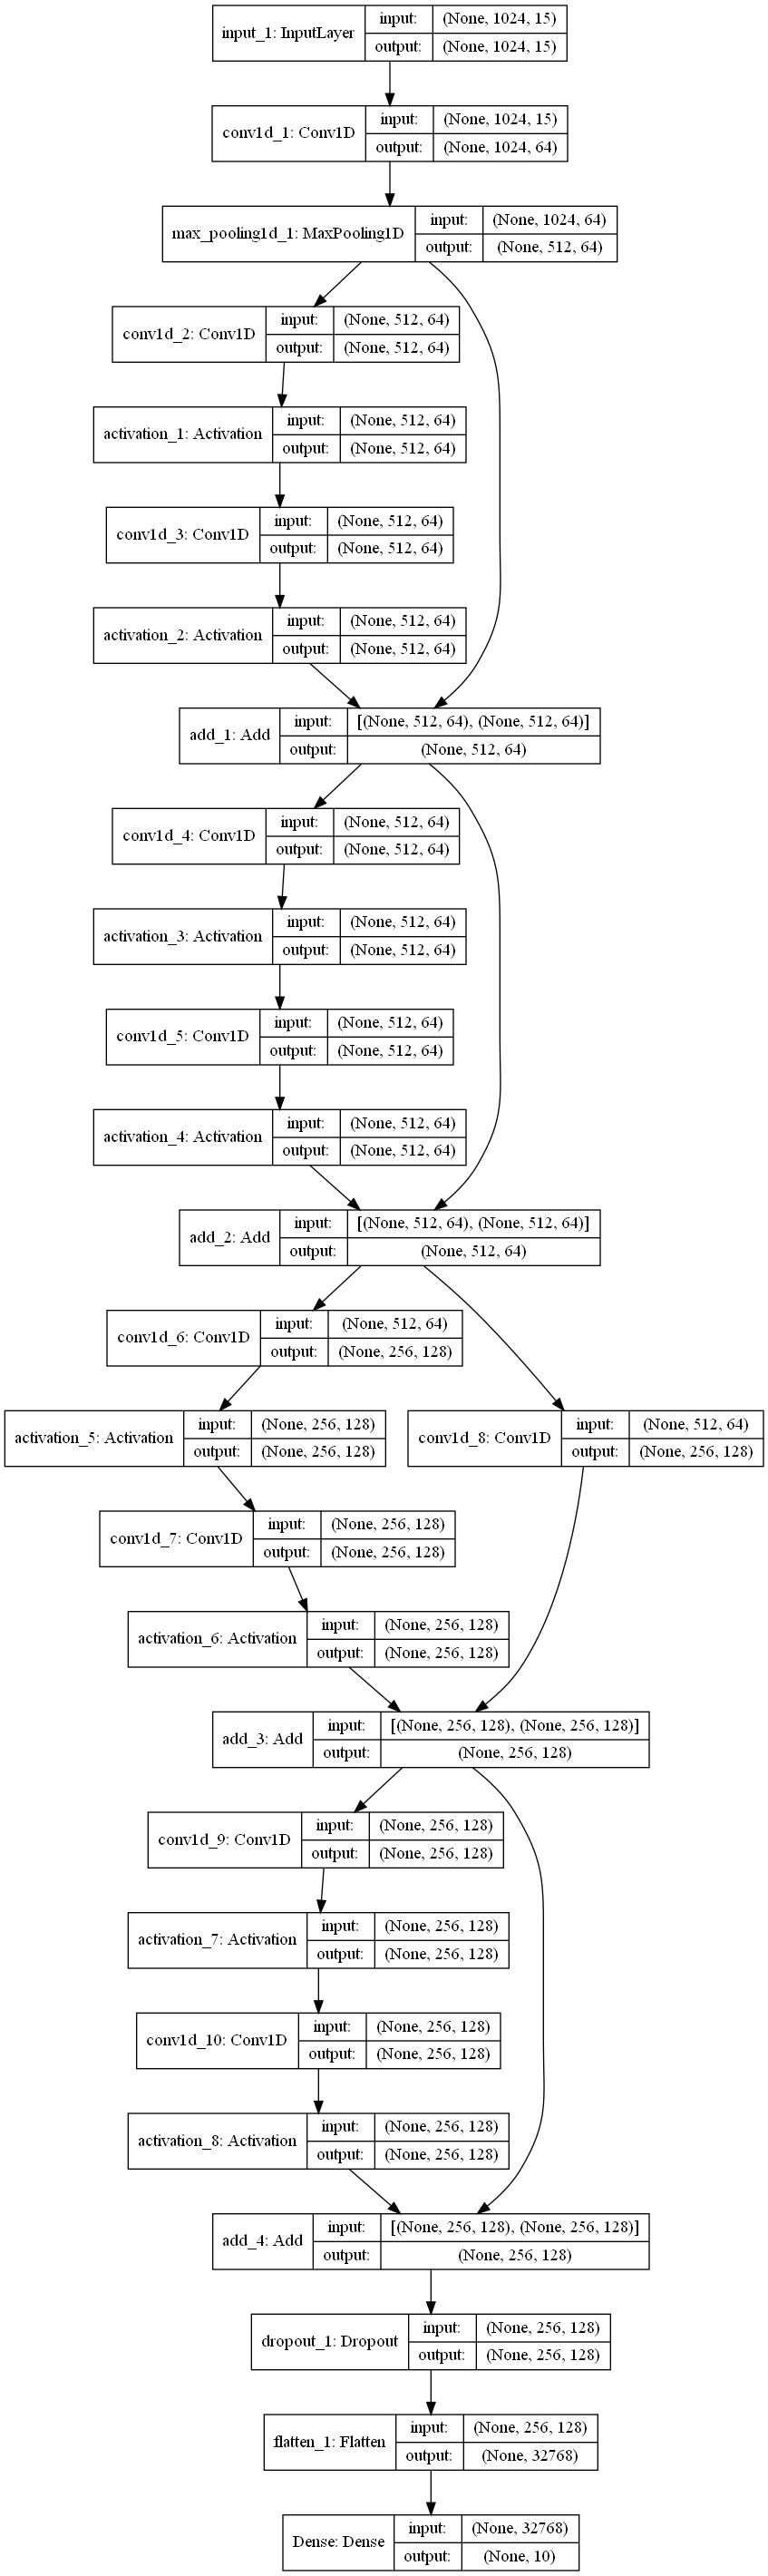

In [27]:
keras.utils.plot_model(newModel,show_shapes = True)

In [28]:
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')  #设置提前中止命令
newModel.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['categorical_accuracy'])
batch_size = 32
epochs = 100
# history = newModel.fit([train_x], one_hot_train_y, batch_size, epochs,validation_data=(test_x, one_hot_test_y),callbacks = [monitor])
history = newModel.fit([train_x], one_hot_train_y, batch_size, epochs,validation_data=(test_x, one_hot_test_y))

Train on 3000 samples, validate on 3000 samples
Epoch 1/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.1221 - categorical_accuracy: 0.2787 - val_loss: 0.1092 - val_categorical_accuracy: 0.2803
Epoch 2/100
3000/3000 [==============================] - 2s 731us/step - loss: 0.1072 - categorical_accuracy: 0.2963 - val_loss: 0.1044 - val_categorical_accuracy: 0.2990
Epoch 3/100
3000/3000 [==============================] - 2s 728us/step - loss: 0.1041 - categorical_accuracy: 0.2990 - val_loss: 0.1026 - val_categorical_accuracy: 0.3000
Epoch 4/100
3000/3000 [==============================] - 2s 728us/step - loss: 0.0898 - categorical_accuracy: 0.3723 - val_loss: 0.0833 - val_categorical_accuracy: 0.4000
Epoch 5/100
3000/3000 [==============================] - 2s 727us/step - loss: 0.0778 - categorical_accuracy: 0.4307 - val_loss: 0.0685 - val_categorical_accuracy: 0.4960
Epoch 6/100
3000/3000 [==============================] - 2s 731us/step - loss: 0.0671 - categorical

3000/3000 [==============================] - 2s 770us/step - loss: 1.3501e-06 - categorical_accuracy: 1.0000 - val_loss: 4.8293e-05 - val_categorical_accuracy: 0.9997
Epoch 95/100
3000/3000 [==============================] - 2s 770us/step - loss: 1.3775e-06 - categorical_accuracy: 1.0000 - val_loss: 5.1256e-05 - val_categorical_accuracy: 0.9997
Epoch 96/100
3000/3000 [==============================] - 2s 769us/step - loss: 1.2268e-06 - categorical_accuracy: 1.0000 - val_loss: 4.6030e-05 - val_categorical_accuracy: 0.9997
Epoch 97/100
3000/3000 [==============================] - 2s 770us/step - loss: 1.0822e-06 - categorical_accuracy: 1.0000 - val_loss: 4.5187e-05 - val_categorical_accuracy: 0.9997
Epoch 98/100
3000/3000 [==============================] - 2s 771us/step - loss: 1.0742e-06 - categorical_accuracy: 1.0000 - val_loss: 4.2910e-05 - val_categorical_accuracy: 0.9997
Epoch 99/100
3000/3000 [==============================] - 2s 772us/step - loss: 9.3125e-07 - categorical_accuracy

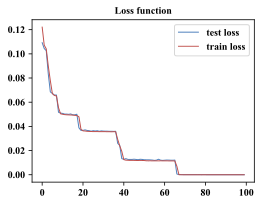

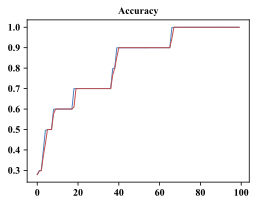

In [50]:
plt.figure(figsize=(4,3))
plt.plot(history.history['val_loss'],color = '#4f81bd',linewidth = 1,label=('test loss'))
plt.plot(history.history['loss'],color ='#c0504d' ,linewidth = 1,label=('train loss'))
plt.xticks(fontproperties = 'Times New Roman', size = 10)
plt.yticks(fontproperties = 'Times New Roman', size = 10)
plt.title('Loss function',fontproperties = 'Times New Roman', size = 10)
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 10})
# plt.savefig('C:\\Users\\shamrockyj\\Desktop\\迁移学习loss3.png', dpi=500, bbox_inches='tight') 

plt.figure(figsize=(4,3))
plt.plot(history.history['val_categorical_accuracy'],linewidth = 1,color = '#4f81bd',label=('test acc'))
plt.plot(history.history['categorical_accuracy'],linewidth = 1,color ='#c0504d',label=('train acc'))
plt.xticks(fontproperties = 'Times New Roman', size = 10)
plt.yticks(fontproperties = 'Times New Roman', size = 10)
plt.title('Accuracy',fontproperties = 'Times New Roman', size = 10)
# plt.legend(prop={'family' : 'Times New Roman', 'size'   : 10})
# plt.savefig('C:\\Users\\shamrockyj\\Desktop\\迁移学习accuracy3.png', dpi=500, bbox_inches='tight') 
# pd.DataFrame(history.history['val_loss']).to_csv('C:\\Users\\shamrockyj\\Desktop\\迁移模型loss3.csv')
# pd.DataFrame(history.history['val_categorical_accuracy']).to_csv('C:\\Users\\shamrockyj\\Desktop\\迁移模型acc3.csv')

In [30]:
# 保存损失函数和准确率
# pd.DataFrame(history.history['val_categorical_accuracy']).to_csv("C:/Users/shamrockyj/Desktop/毕设：航空发动机智能运维与健康管理/数据/训练数据/AccNI-3-4.csv")

In [31]:
# model.save('baseModel.h5')

In [45]:
predict_array = newModel.predict(test_x)
# 计算测试精度
y_predict = np.zeros_like(predict_array)
y_predict[np.arange(len(predict_array)), predict_array.argmax(axis=1)] = 1 #将每行最大值置1，最大值即为预测标签
temp = np.sum(abs(y_predict - one_hot_test_y), axis=1) #将y_predict与test_y相减，每一行取绝对值后相加，不为0的元素即为错误预测
temp[temp>0]=1 #将每一行中不为零的数置1
accuracy = (len(temp)-temp.sum())/len(temp)
print("Test accuracy is:", accuracy)

Test accuracy is: 0.9996666666666667


In [46]:
label = [np.argmax(item) for item in y_predict]
label
s=set()#定义集合|
for i in label:#循环列表中的元素
    if i not in s:#如果i不在集合中
        s.add(i)#将i添加到集合中
        print('Name:{}\tCount:{}'.format(i+1,label.count(i)))#格式化打印出i、i的count数

Name:5	Count:301
Name:2	Count:300
Name:7	Count:300
Name:1	Count:300
Name:4	Count:300
Name:9	Count:299
Name:3	Count:300
Name:10	Count:300
Name:8	Count:300
Name:6	Count:300
